In [4]:
import os
import chromadb.utils.embedding_functions as embedding_functions
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

## 如果报错：SSLError:(MaxRetryEror("SOCKSHTTPSomectionpool(host='huggingface.co', port-443)，注意挂上梯子并添加以下代码：
# http://127.0.0.1:1080/pac?auth=6kW2t5wCi1UNt1VioOiy&t=202404181401516765
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:1080/pac?auth=6kW2t5wCi1UNt1VioOiy&t=202404181401516765' # 7890改为自己的梯子端口
os.environ["HTTP_PROXY"]  = 'http://127.0.0.1:1080/pac?auth=6kW2t5wCi1UNt1VioOiy&t=202404181401516765'

# 读取OpenAI的api key
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) 
openai_api_key = os.environ['OPENAI_API_KEY']

# chromadb支持的嵌入函数有许多种，这里介绍常用的几种：
# 参考资料：https://docs.trychroma.com/embeddings
# 方式1：默认嵌入函数，需要下载模型，本地计算。英文文本表现不错，中文文本表现一般
# embedding_function = SentenceTransformerEmbeddingFunction()

# 方式2：OpenAI的嵌入函数，直接调用OpenAI的接口，无需下载模型，推荐
embedding_function = embedding_functions.OpenAIEmbeddingFunction(
                api_key=openai_api_key,
                model_name="text-embedding-ada-002"
            )

# 方式3：HuggingFace的嵌入函数，需要下载模型，本地计算，对网络要求高
# embedding_function = embedding_functions.HuggingFaceEmbeddingFunction(
#     api_key="hf_",  # 填入你的 huggingface Access Token
#     model_name="jinaai/jina-embeddings-v2-base-zh"  # 指定模型
# )
## 中文备选模型
# jinaai/jina-embeddings-v2-base-zh
# GanymedeNil/text2vec-large-chinese
# BAAI/bge-large-zh-v1.5
# BAAI/bge-small-zh-v1.5


# 初始化chroma，英文文档
# chroma_collection = load_chroma(filename='./data/microsoft_annual_report_2022.pdf', \
#                                 collection_name='microsoft_annual_report_2022', \
#                                 embedding_function=embedding_function,
#                                 langcode='en')

# 初始化chroma，中文文档
chroma_collection = load_chroma(filename='./data/2024年北京市政府工作报告.pdf', \
                                collection_name='beijing_annual_report_2024', \
                                embedding_function=embedding_function,
                                langcode='zh')  # 注意中文文档将langcode改为'zh'
chroma_collection.count()

UniqueConstraintError: Collection beijing_annual_report_2024 already exists

In [3]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) 
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [9]:
import umap
import numpy as np
from tqdm import tqdm

In [5]:
def project_embeddings(embeddings, umap_transform):
    """
    用 UMAP 将高维嵌入向量投影到二维向量空间。
    
    Args:
        embeddings (list): 高维嵌入向量。
        umap_transform (umap.UMAP): UMAP模型。

    Returns:
        umap_embeddings (np.ndarray): 二维嵌入向量矩阵。
    """
    
    umap_embeddings = np.empty((len(embeddings),2))
    # 为保证结果可复现，逐个进行umap转换
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])

    return umap_embeddings  

In [7]:
import umap
import numpy as np
from tqdm import tqdm

In [8]:
import umap.umap_ as umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

d:\python_env\py310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 1028/1028 [09:51<00:00,  1.74it/s]


In [10]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            # 设定一个对话场景，模型被告知扮演一个专业的财经研究助理。
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. " # 系统提示
        },
        {"role": "user", "content": query} # 通过查询作为内容
    ] 
    
    # 定义如何提示模型
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [11]:
original_query = "推动北京财政收入增长的因素是什么?"
# 生成假设答案
hypothetical_answer = augment_query_generated(original_query)
# 联合查询
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

推动北京财政收入增长的因素是什么?
北京财政收入增长的因素有多个，其中一些关键因素包括经济增长、税收政策调整、市场监管力度加强、投资回报增加以及财政支出结构优化等。举个例子，北京市
府近年来通过促进科技创新和吸引外商投资，推动了本地经济的发展，从而带动了财政收入的增长。另外，北京通过改革税收政策，提高了税收征收的效率，也为财
收入的增长做出了贡献。


In [12]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

提高财政投入力度

更好发挥积极财政政策作用

持续增加城乡居民收入

居民收入增长与经济增长同步

居民收入增长与经济增长同步



In [13]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


(2.421052634716034, 9.080853521823883, 6.905082368850708, 14.442727422714233)

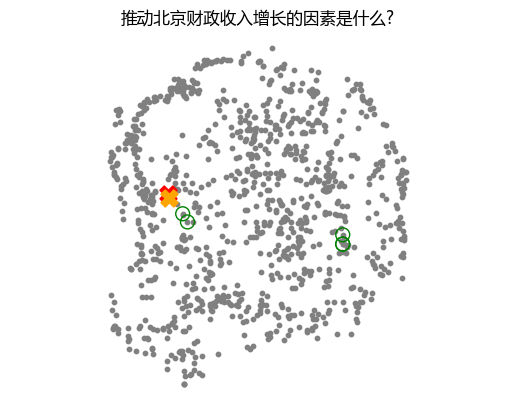

In [14]:
import matplotlib.pyplot as plt


plt.figure()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑，显示中文

plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
#查询的结果
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
#原始查询
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
#假设答案的查询
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

In [15]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            # 为模型提供指令，告诉它扮演一个有用的财经研究助理。
            # 指令包括基于提供的查询生成最多五个相关的额外查询问题。
            # 提示模型生成的问题应该简短，不包含复合句，并涵盖主题的不同方面。
            # 要确保问题是完整的，并且与原始查询相关联。
            # 输出格式为每行一个问题，不要对问题编号。
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [16]:
original_query = "推动北京财政收入增长的因素是什么?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- 北京财政收入的历史增长趋势如何？
- 北京财政支出的主要领域是什么？
- 北京财政收入的税收构成是怎样的？
- 北京财政支出的资金运用情况如何？
- 北京财政收入增长是否超过了当地经济增长率？


In [17]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# 对检索到的文档进行重复数据删除
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: 推动北京财政收入增长的因素是什么?

Results:
提高财政投入力度

促进北京普惠健
康保可持续发展

更好发挥积极财政政策作用

持续增加城乡居民收入

推动经济实现质的有效提升和量的合理增长

----------------------------------------------------------------------------------------------------
Query: - 北京财政收入的历史增长趋势如何？

Results:
持续增加城乡居民收入

居民收入增长与经济增长同步

居民收入增长与经济增长同步

提高财政投入力度

经济整体回升向好

----------------------------------------------------------------------------------------------------
Query: - 北京财政支出的主要领域是什么？

Results:
在中共北京市委直接领导下

是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

绿色北京战略实施取得新成效

一是深入落实首都城市战略定位

深化健康北京建设

----------------------------------------------------------------------------------------------------
Query: - 北京财政收入的税收构成是怎样的？

Results:
在中共北京市委直接领导下

是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

我谨代
表北京市人民政府

我代表北京市人民政府

建设更高水平的平安北京

----------------------------------------------------------------------------------------------------
Query: - 北京财政支出的资金运用情况如何？

Results:
提高财政投入力度

更好发挥积极财政政策作用

绿色北京战略实施取得新成效

“三公”经费减少5%；深化全成本
预算绩效管理改革

统筹用好政府投资基金

------------------------------------------

In [18]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


In [19]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


(2.421052634716034, 9.080853521823883, 6.905082368850708, 14.442727422714233)

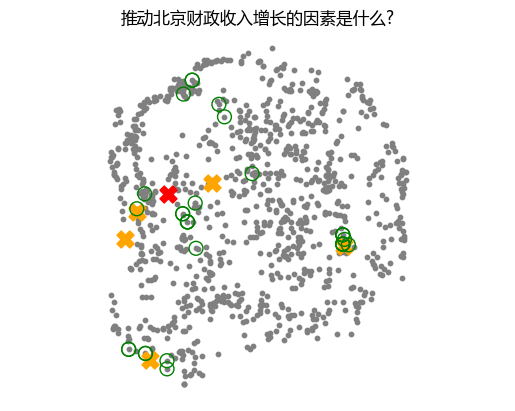

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑，显示中文
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')